In [3]:
%load_ext autoreload
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import os
import pickle
import glob

from oneibl.one import ONE
import alf.io as ioalf
import ibllib.plots as iblplt

from examples.brainbox.plot_peths import filter_trials
from examples.brainbox.plot_peths import calculate_peths
from examples.brainbox.plot_peths import plot_peths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
BIN_SIZE = 0.025  # seconds
SMOOTH_SIZE = 0.025  # seconds; standard deviation of gaussian kernel
PCA_DIMS = 20
CCA_DIMS = PCA_DIMS
N_SPLITS = 5
RNG_SEED = 0

from brainbox.population.cca import *
# get the data from flatiron
# subject = 'ZM_1735'
# date = '2019-08-01'
# number = 1

# one = ONE()
# eid = one.search(subject=subject, date=date, number=number)
# D = one.load(eid[0], download_only=True)
# session_path = Path(D.local_path[0]).parent
session_path = "/media/data/ibl/mainenlab/Subjects/ZM_1735/2019-08-01/001/alf/"
spikes = ioalf.load_object(session_path, 'spikes')
# clusters = ioalf.load_object(session_path, 'clusters')
# channels = ioalf.load_object(session_path, 'channels')
trials = ioalf.load_object(session_path, '_ibl_trials')

# bin spikes
binned_spikes, binned_trialIDs = bin_spikes_trials(spikes, trials, T_BIN=0.025)

# extract 2 populations
data = [binned_spikes[:100, :].T, binned_spikes[100:200, :].T]

# preprocess data
for i, pop in enumerate(data):
    data[i] = preprocess(pop, n_pcs=PCA_DIMS, smoothing_sd=SMOOTH_SIZE)

# split trials
idxs_trial = split_trials(np.unique(binned_trialIDs), n_splits=N_SPLITS, rng_seed=RNG_SEED)
# get train/test indices into spike arrays
idxs_time = split_timepoints(binned_trialIDs, idxs_trial)

In [5]:
# fit cca
ccas = [None for _ in range(N_SPLITS)]
dtype = 'train'
for i, idxs in enumerate(idxs_time):
    ccas[i] = fit_cca(data[0][idxs[dtype], :], data[1][idxs[dtype], :], n_cca_dims=CCA_DIMS)

In [33]:
# plot cca correlations
dtype = 'test'
corrs = [None for _ in range(N_SPLITS)]
for i, idxs in enumerate(idxs_time):
    corrs[i] = get_correlations(ccas[i], data[0][idxs[dtype], :], data[1][idxs[dtype], :])

In [88]:
vals.shape

(20, 5)

In [34]:
vals = np.stack(corrs, axis=1)
means = np.mean(vals, axis=1)
serrs = np.std(vals, axis=1) / np.sqrt(N_SPLITS)

In [42]:
n_regions = 5
cca_list = [[None for _ in range(n_regions)] for _ in range(n_regions)]
means_list = [[None for _ in range(n_regions)] for _ in range(n_regions)]
serrs_list = [[None for _ in range(n_regions)] for _ in range(n_regions)]
for i in range(n_regions-1):
    for j in range(i+1, n_regions):
        cca_list[i][j] = ccas
        dtype = 'test'
        corrs = [None for _ in range(N_SPLITS)]
        for i, idxs in enumerate(idxs_time):
            corrs[i] = get_correlations(ccas[i], data[0][idxs[dtype], :], data[1][idxs[dtype], :])
        vals = np.stack(corrs, axis=1)
        means_list[i][j] = np.mean(vals, axis=1)
        serrs_list[i][j] = np.std(vals, axis=1) / np.sqrt(N_SPLITS)

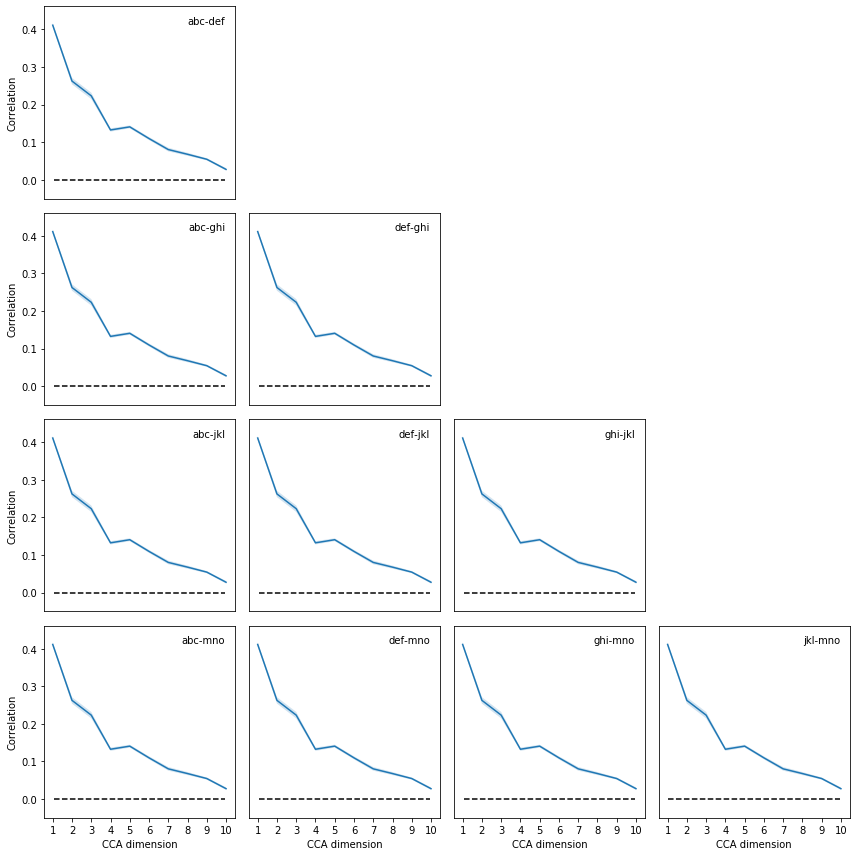

In [84]:
# def plot_interregional_subspace_overlap_matrix(
#         self, measure='max', view='diff', dim=0):
#     """
#     plot angle between subspaces across regions
#     WARNING: currently hardcoded for beh and nonbeh states

#     Args:
#         self (CCAByStateRegion object)
#         measure (str): 'max' | 'min' | 'avg'
#         view (str): 'beh' | 'nonbeh' | 'diff'
#         dim (int)
#     """

n_regions = len(means_list)
n_dims = 10

max_val = 0
for r in range(1, n_regions):
    for c in range(r):
        tmp = means_list[i][j]
        if tmp is not None:
            max_val = np.max([max_val, np.max(tmp)])

# plot with matplotlib
fig, axes = plt.subplots(n_regions-1, n_regions-1, figsize=(12, 12))
for r in range(n_regions-1):
    for c in range(n_regions-1):
        axes[r, c].axis('off')
        
region_names = ['abc', 'def', 'ghi', 'jkl', 'mno']
for r in range(1, n_regions):
    for c in range(r):
        ax = axes[r-1, c]
        ax.axis('on')
        ax = plot_correlations(means_list[i][j][:n_dims], serrs_list[i][j][:n_dims], ax=ax)
        ax.axhline(y=0, xmin=0.05, xmax=0.95, linestyle='--', color='k')
        ax.text(
            x=0.95, y=0.95, s=str('%s-%s' % (region_names[c], region_names[r])), 
            horizontalalignment='right',
            verticalalignment='top', 
            transform=ax.transAxes)
        ax.set_ylim([-0.05, max_val+0.05])
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
#     ax.set_title(reg)

plt.tight_layout()
# plt.suptitle('Angles between pairs of CCA models - %s' % view)

plt.show()